# How to use the library Wildlife datasets

This notebook shows an introduction to the library [Wildlife datasets](https://github.com/WildlifeDatasets/wildlife-datasets), which summarizes publicly available animal datasets used for re-identification. That means recognizing individual animals, which is a much more difficult task than the usual task of recognizing species.

In [12]:
import os
import sys
sys.path.append('..')
import pandas as pd
from wildlife_datasets import datasets
from wildlife_datasets.analysis import display_statistics
from wildlife_datasets.splits import visualize_split
from wildlife_datasets.splits import TimeCutoffSplit, TimeProportionSplit

The dataset SeaTurtleIDHeads must be already downloaded and saved in the `root` folder.

In [13]:
root = '../data/SeaTurtleIDHeads'

## Loading the dataset

We create the dataset `d`. We can display its metadata by `d.metadata` or the dataframe `d.df` summarizing the images in the dataset. The dataframe for SeaTurtleIDHeads has 7582 rows, where each row describes one image. Each image has its id, path and the identity (name) of the animal which it contains. Then there may be additional information such as the date when the image was taken or the image orientation.

In [14]:
d = datasets.SeaTurtleIDHeads(root)
df = d.df
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df

,image_id,identity,path,date,orientation,year
0,0,t281,images\t281\ILXxnZwvNh.JPG,2016-07-11,topleft,2016
1,1,t281,images\t281\DjtwgIIURL.JPG,2016-07-11,right,2016
2,2,t281,images\t281\hHfmOdhzDU.JPG,2016-07-11,topleft,2016
3,3,t281,images\t281\gTovpgwOut.JPG,2016-07-11,left,2016
4,4,t281,images\t281\yUETlrBYAp.JPG,2016-07-11,right,2016
...,...,...,...,...,...,...
7577,7769,t157,images\t157\onmATVzAyB.JPG,2015-06-30,topleft,2015
7578,7770,t157,images\t157\FQNPajeBYd.JPG,2015-06-30,topright,2015
7579,7771,t157,images\t157\cwXNsIVEFz.JPG,2015-06-30,top,2015
7580,7772,t157,images\t157\blzCVWUqSI.JPG,2015-06-30,right,2015


There is an in-built function to provide basic dataset summary. The SeaTurtleIDHeads dataset contains 400 individual animals. The plot shows that the number of photos per animal has a highly unequal distribution. This is a sign of a dataset taken in the wild, where the photo setup cannot be made as desired and consequently, there are not enough photos for some individuals.

Number of identitites            400
Number of all animals            7582
Number of animals with one image 2
Number of unidentified animals   0
Images span                      9.0 years


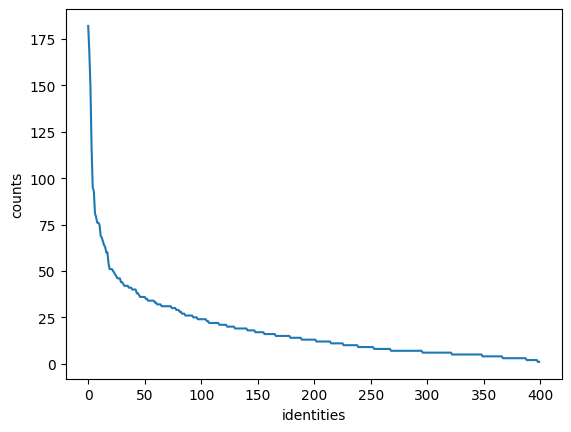

In [15]:
display_statistics(df)

## How to recognize individual turtles

Another in-built function plots a random selection of images from the dataset. It is clear that the images have different orientation (they were taken from different angles) and the photo quality is extremely varying. Also all photos are taken in the water, which differs from most existing datasets.

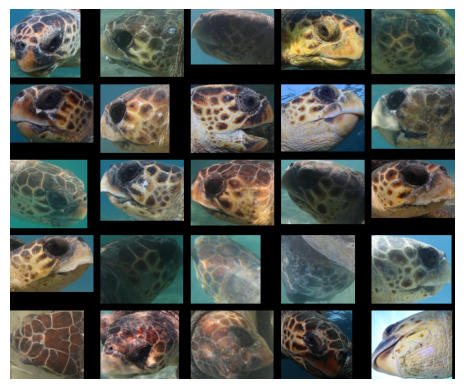

In [16]:
d.plot_grid(n_cols=5);

We may plot only photos depicting the left size of the turtle heads. Individual turtles may be recognized by the shape of the three post-ocular scutes. A careful examination shows that the shape and size of these scutes are different for each individual.

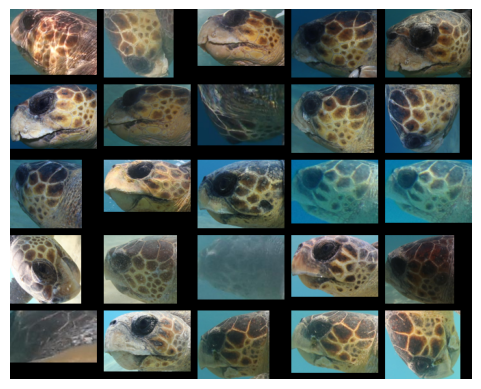

In [17]:
d.plot_grid(n_cols=5, idx=df['orientation']=='left');

To show that the post-ocular scutes are stable throughout the turtle life, we select the individual t033 and plot the grid again. The three post-ocular scutes indeed remain stable, the top scute is a short pentagon, the middle scute is an elongated pentagon and the bottom scute is a short rectangle. Even though their shape remains stable, their colourations change and injuries may appear. Naturally, this complicates the re-identification task.

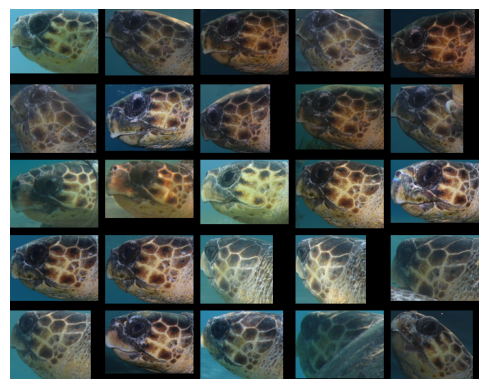

In [18]:
d.plot_grid(n_cols=5, idx=(df['orientation']=='left')*(df['identity']=='t033'));

## How images change in time

An important aspect of real-world tasks is the time dimension. Many datasets are taken only within days, which makes them rather artificial. We plot the evolution of the turtle t033 between 2012 and 2021. The first obvious difference is the photo quality. Even though all photos were taken by one photographer, the acquiral of a better camera in 2014 and a flash in 2019 makes the photo quality increase in those years.

Another aspect in long-term datasets are the changes in coloration and injuries. For example, the middle scute is almost completely dark in 2015 but many light spots appear in 2016, or the turtle suffered many injuries in 2021.

Year 2012


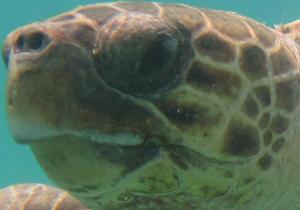

Year 2013


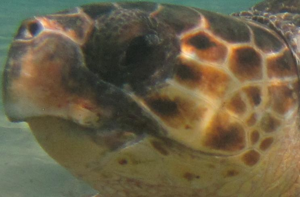

Year 2015


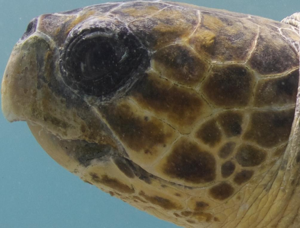

Year 2016


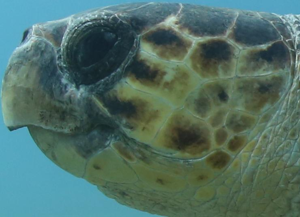

Year 2017


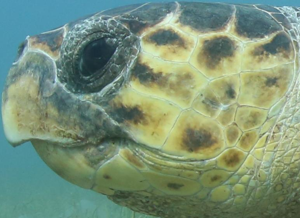

Year 2019


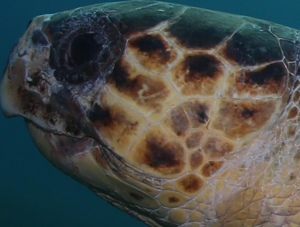

Year 2020


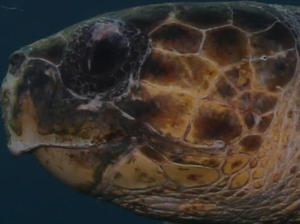

Year 2021


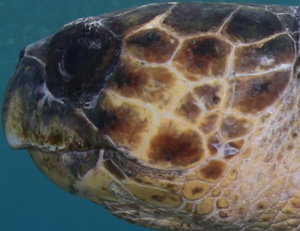

In [19]:
df_t033 = df[df['identity'] == 't033']
for year, df_t033_year in df_t033[df_t033['orientation'] == 'left'].sort_values('year').groupby('year'):
    print(f"Year {year}")
    display(datasets.load_image(os.path.join(root, df_t033_year.iloc[0]['path']), max_size=300))

## How to properly split the dataset

The previous part argued that dates are important for real-world analysis. We implemented two splits which take them into account. The cutoff split selects a cutoff year (2015 in this case); all images taken prior to the cutoff year go into the training set (blue circles) and the remaining images into the testing set (black stars). This is visualized in the next graph.

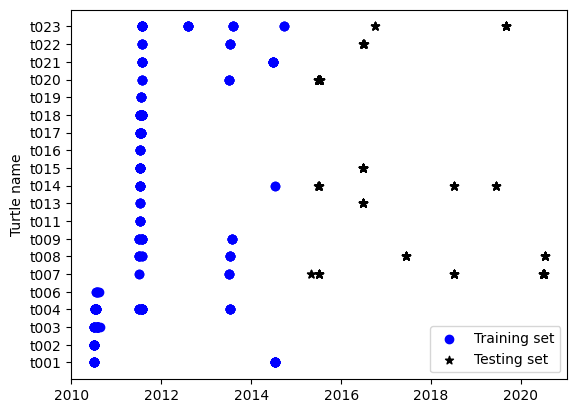

In [20]:
splitter = TimeCutoffSplit(2015, test_one_year_only=False)
idx_train, idx_test = splitter.split(df)[0]
df_train, df_test = df.loc[idx_train], df.loc[idx_test]
visualize_split(df_train, df_test, selection=20)

This split sharply contrasts with the commonly used random split, where the dates of images in the training and testing set usually overlap. Since images taken at the same date often share some external factors (such as background or lightning), classifiers may focus on these factors instead of learning a hidden representation of each individual. Therefore, the random split creates an undesired testing-to-training leak. This also implies that random splits result in an artificaially inflated performance metrics. 

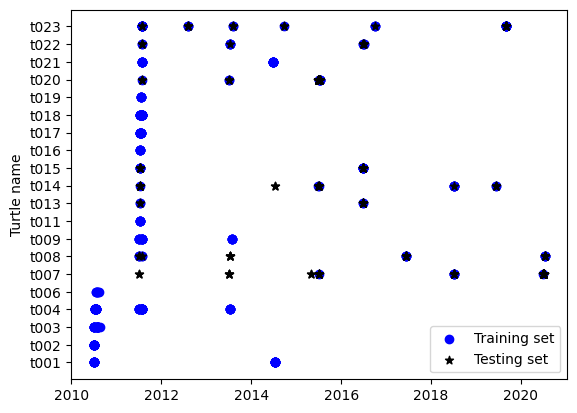

In [21]:
idx_train, idx_test = splitter.resplit_random(df, idx_train, idx_test)
df_train, df_test = df.loc[idx_train], df.loc[idx_test]
visualize_split(df_train, df_test, selection=20)

The cutoff split results in the open-set split, where some inidividuals may be only in the testing set. This problem may be difficult to handle because standard predictions based on the training set only cannot be used. We provide an alternative time-proportion split, where the cutoff date differs for each individual. Therefore, for each individual, the dates from the training and testing images are disjoint. This should also prevent the testing-to-training leakage of the random split.

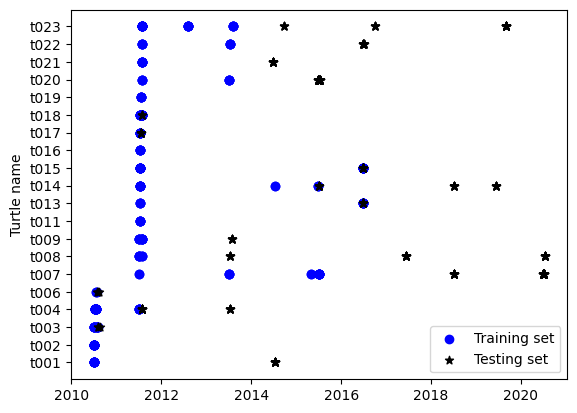

In [22]:
splitter = TimeProportionSplit()
idx_train, idx_test = splitter.split(df)[0]
df_train, df_test = df.loc[idx_train], df.loc[idx_test]
visualize_split(df_train, df_test, selection=20)